In [53]:
import importlib
import geolo as gl
importlib.reload(gl)

<module 'geolo' from '/home/lpga/gravimetry-mantiqueira/data/geological_map/code/geolo.py'>

In [35]:
import plotagem as plot

In [36]:
import geopandas as gpd

In [37]:
# Caminhos dos arquivos shapefile
shp_paths = {
    "rio_grande_do_sul": "../data/sig_rio_grande_do_sul/Litologia/riograndedosul_lito.shp",
    "parana": "../data/sig_geologia_estado_do_parana_vf/Litologia/Parana_lito.shp",
    "santa_catarina": "../data/sig_santa_catarina/Litologia/Santa_Catarina_lito.shp",
    "sao_paulo": "../data/sig_sao_paulo/Litologia/spaulo_lito.shp",
    "mato_grosso_do_sul": "../data/sig_mato_grosso_do_sul/Litologia/mgsul_lito.shp",
    "minas_gerais": "../data/sig_minas_gerais/Litologia/MinasGerais_lito.shp"
}

# Carregar shapefiles em GeoDataFrames
gdf_rio_grande_do_sul = gpd.read_file(shp_paths["rio_grande_do_sul"])
gdf_parana           = gpd.read_file(shp_paths["parana"])
gdf_santa_catarina   = gpd.read_file(shp_paths["santa_catarina"])
gdf_sao_paulo        = gpd.read_file(shp_paths["sao_paulo"])
gdf_mato_grosso_do_sul = gpd.read_file(shp_paths["mato_grosso_do_sul"])
gdf_minas_gerais = gpd.read_file(shp_paths["minas_gerais"])

# Conferir rapidamente
for nome, gdf in zip(shp_paths.keys(), [gdf_rio_grande_do_sul, gdf_parana, gdf_santa_catarina, gdf_sao_paulo, gdf_mato_grosso_do_sul, gdf_minas_gerais]):
    print(f"{nome}: {len(gdf)} feições, CRS={gdf.crs}")


rio_grande_do_sul: 3362 feições, CRS=EPSG:4674
parana: 3192 feições, CRS=EPSG:5880
santa_catarina: 2941 feições, CRS=EPSG:4674
sao_paulo: 2108 feições, CRS=EPSG:4674
mato_grosso_do_sul: 870 feições, CRS=EPSG:4674
minas_gerais: 8895 feições, CRS=EPSG:4674


In [38]:
styler = gl.GeoSiglaStyler()

styler.load_sigla_qml([
    "../data/sig_rio_grande_do_sul/Litologia/riograndedosul_lito.qml",
    "../data/sig_geologia_estado_do_parana_vf/Litologia/Parana_lito.qml",
    "../data/sig_santa_catarina/Litologia/Santa_Catarina_lito.qml",
    "../data/sig_sao_paulo/Litologia/spaulo_lito.qml",
    "../data/sig_mato_grosso_do_sul/Litologia/mgsul_lito.qml",
    "../data/sig_minas_gerais/Litologia/MinasGerais_lito.qml"
])

In [39]:
# 1) combinar + classificar (sem dissolve)
g_base = styler.combine_and_classify(
    gdfs=[gdf_rio_grande_do_sul, gdf_parana,
          gdf_santa_catarina, gdf_sao_paulo,
          gdf_mato_grosso_do_sul, gdf_minas_gerais],
    fields_to_keep=[
        "SIGLA_UNID","SIGLAS_ANT","NOME_UNIDA","HIERARQUIA",
        "EON_IDAD_M","ERA_MAXIMA","PERIODO_MA","EPOCA_MAX",
        "EON_IDAD_1","ERA_MINIMA","PERIODO_MI","EPOCA_MIN",
        "IDADE_MAX", "IDADE_MIN", "CLASSE_ROC","CLASSE_R_1"
    ],
    enforce_mode="flag",
)

In [40]:
bbox = {"min_lon": -56.7, "max_lon": -46, "min_lat": -34.8, "max_lat": -21.5}

# 2) recortar (isso já “limpa” estado de cores/legenda anteriores)
g_clip = styler.clip_to_bbox(g_base, bbox)

In [41]:
# 3) (opcional) construir o mapa de cores já com base no recorte
cmap, audit = styler.build_color_map_from(g_clip, attr="coarse_grp")

In [42]:
gdf_plot = styler.g_clipped if styler.g_clipped is not None else styler.g_base
simp = styler.simplified_legend_dict(gdf=gdf_plot)

simp

OrderedDict([('Fanerozoico',
              OrderedDict([('Cenozoico',
                            [{'group': 'Q2|x',
                              'idade_max': 0.0,
                              'idade_min': 0.0,
                              'color': '#97E4F9'},
                             {'group': 'Q2|fm',
                              'idade_max': 0.0115,
                              'idade_min': 0.0,
                              'color': '#FAEBA3'},
                             {'group': 'Q2|fr',
                              'idade_max': 0.0115,
                              'idade_min': 0.0,
                              'color': '#FFC4E9'},
                             {'group': 'Q2|ma',
                              'idade_max': 0.0115,
                              'idade_min': 0.0,
                              'color': '#E3D969'},
                             {'group': 'Q2|pr',
                              'idade_max': 0.0115,
                              'idade_min': 

In [43]:
# 4) (opcional) dissolver
g_diss = styler.dissolve_by_attr(g_clip, attr="coarse_grp")

In [44]:
import shapely, shapely.strtree as st
print(shapely.__version__)
print("has query_bulk?", hasattr(st.STRtree, "query_bulk"))
print("has nearest?", hasattr(st.STRtree, "nearest"))


2.1.1
has query_bulk? False
has nearest? True


In [45]:
scale = styler.width_to_scale(gdf=g_diss)
print(scale)

10000000


In [ ]:
g_cull = styler.cull_small_parts_by_scale(g_diss)

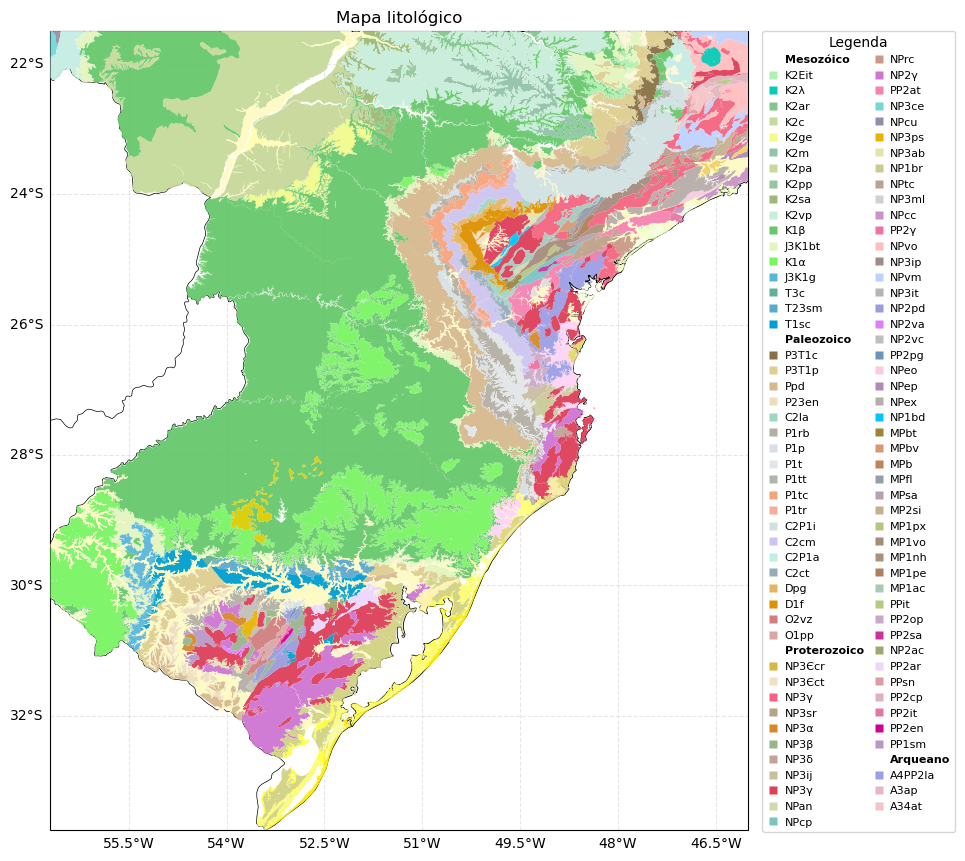

In [57]:
plot.plot_geodf_by_simplified_legend(
    g_cull,
    simp,
    group_attr="coarse_grp",
    title="Mapa litológico",
    projection="EPSG:4674",
    data_crs="EPSG:4674",
    figure_path="../data/out/mapa.png",
    show_states=False,
    states_resolution="50m",
    legend_outside=True,
    legend_cols=2,
    legend_h="right",          # "left" | "right"
    legend_v="up"              # "up"   | "down"
)

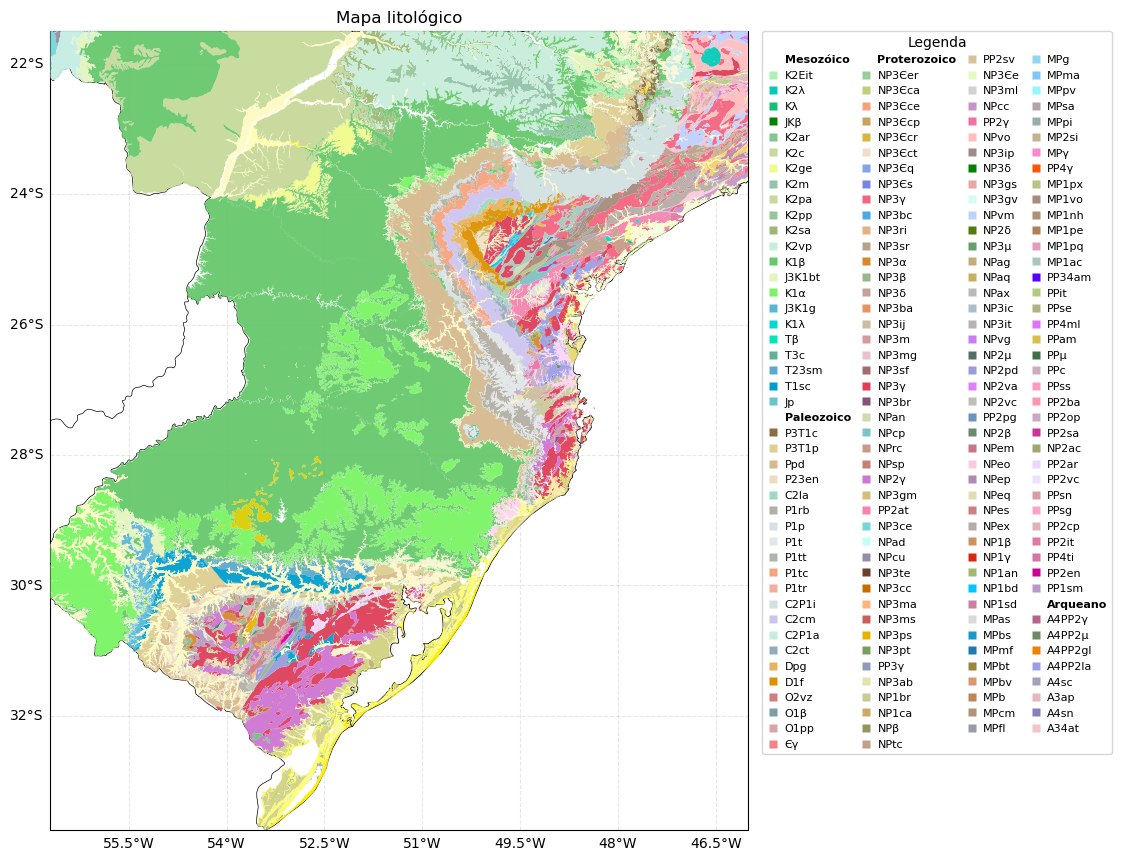

In [50]:


plot.plot_geodf_by_simplified_legend(
    g_diss,
    simp,
    group_attr="coarse_grp",
    title="Mapa litológico",
    projection="EPSG:4674",
    data_crs="EPSG:4674",
    figure_path="../data/out/mapa.png",
    show_states=False,
    states_resolution="50m",
    legend_outside=True,
    legend_cols=4,
    legend_h="right",          # "left" | "right"
    legend_v="up"              # "up"   | "down"
)


In [52]:
# 5) exportar QML usando g_diss como camada alvo e g_clip como base para os mixes
qml_path, audit_path = styler.export_qml("../data/out/merged.qml", gdf=g_cull, attr="coarse_grp", source_gdf_for_mix=g_cull)


# 7) shapefile final
shp_path = styler.save_shp(g_cull, "../data/out/merged.shp")

/home/lpga/gravimetry-mantiqueira/data/geological_map/code/geolo.py:1787: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  g.to_file(out_path, driver="ESRI Shapefile", encoding="utf-8")
/home/lpga/miniforge3/envs/gravimetry-mantiqueira/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'coarse_grp_part' to 'coarse_g_1'
  ogr_write(
